Text(0.5, 1.0, 'Time-Frequency spectrogram of signal')

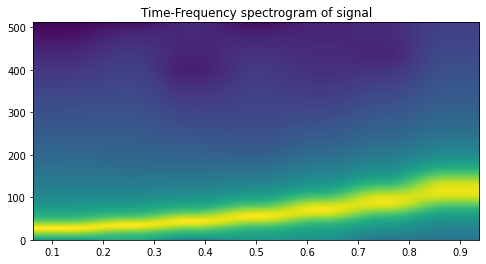

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from kymjtfs.utils import exp_chirp

x = exp_chirp(rate=2, f0=20)

plt.figure(figsize=(8, 4))
plt.specgram(x, Fs=1024)
plt.title("Time-Frequency spectrogram of signal")